# Perceptual hash


- Reduce size to 32x32

- Reduce color to grayscale.

- Compute a 32x32 DCT.

- Reduce the DCT keeping the top-left 8x8. 

- Compute the mean DCT value (using only the 8x8 DCT low-frequency values and excluding the first term since the DC coefficient can be significantly different from the other values and will throw off the average)


- Create the 64 hash bits to 0 or 1 depending on whether each of the 64 DCT values are above or below the average value. 

- Construct the hash setting the 64 bits into a 64-bit integer. The order does not matter, just as long as you are consistent. 



In [112]:
using FFTW, Statistics, ImageTransformations, Images, Plots
import ImageTransformations.Linear as Linear

# Perceptual Hashing


Evaluation: https://idealo.github.io/imagededup/user_guide/benchmarks/

In [13]:
hash_size = 8
image = load("./images/logo1.png");

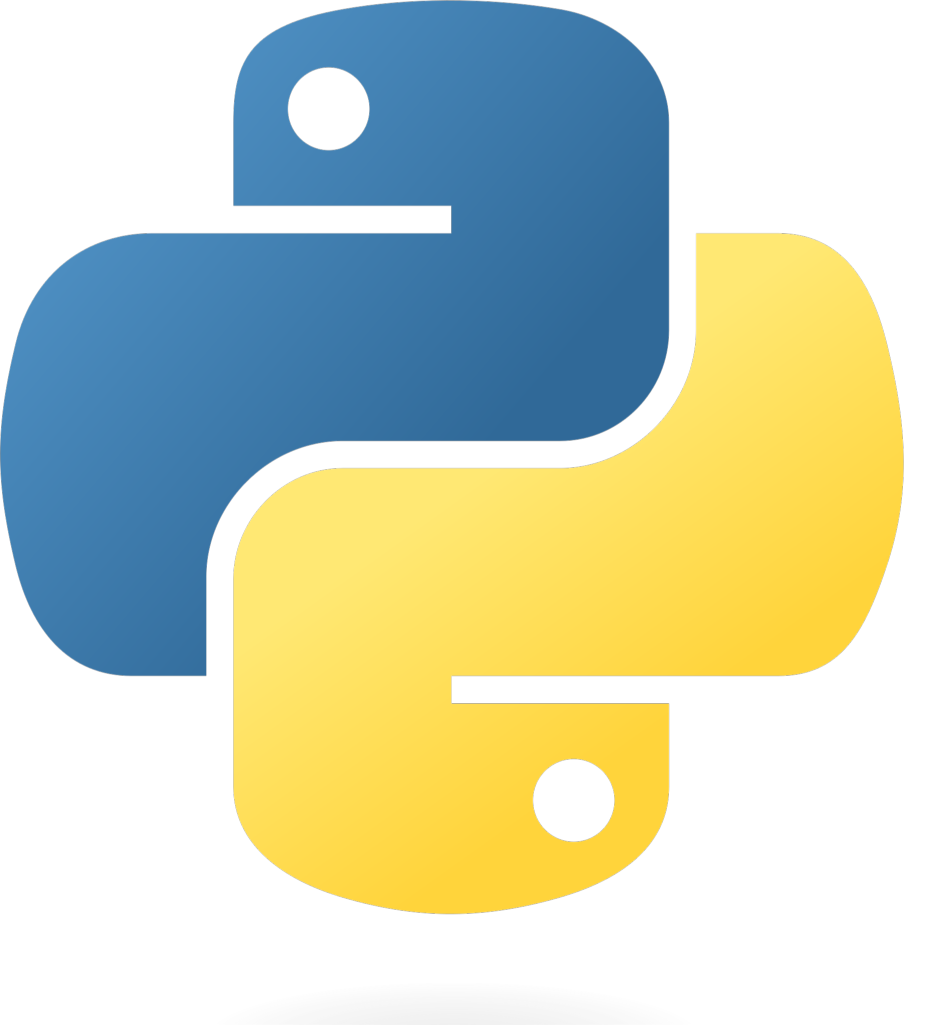

In [14]:
image

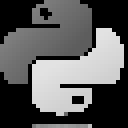

In [98]:
img_resized = imresize(image, 32, 32, method=Linear())
img_resized_gray = Gray.(img_resized)

In [124]:
#dct(img_resized_gray)
dct_image = dct(reinterpret(UInt8, img_resized_gray));

In [ ]:
hash_size = 8

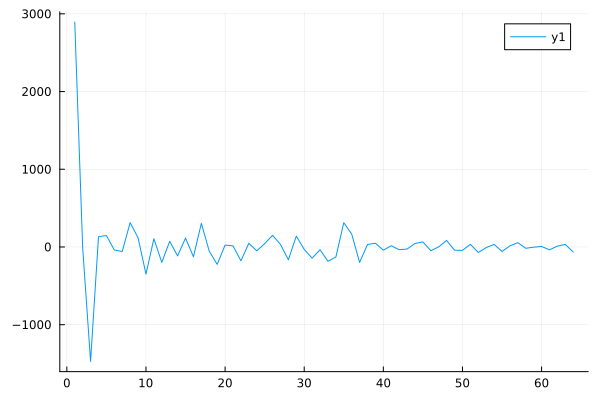

In [130]:
plot(dct_image[:][1:64])

In [139]:
mean(dct_image), maximum(dct_image), sum(dct_image)

(0.5103664526624759, 2895.1875000000005, 522.6152475263754)

In [ ]:
plot

In [105]:
img_resized_gray[1]

In [96]:
channelview(img_resized_gray)

32×32 reinterpret(reshape, N0f8, ::Array{Gray{N0f8},2}) with eltype N0f8:
 0.0    0.0    0.0    0.0    0.0    0.0    …  0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0    …  0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.49   0.482     0.886  0.0    0.0    0.0    0.0
 0.0    0.0    0.494  0.49   0.482  0.478     0.878  0.875  0.0    0.0    0.0
 0.0    0.494  0.49   0.486  0.478  0.471     0.875  0.871  0.867  0.0    0.0
 0.0    0.49   0.486  0.478  0.471  0.463  …  0.867  0.863  0.859  0.0    0.0
 0.49   0.486  0.478  0.471  0.463  0.455     0.859  0.855  0.855  0

In [89]:
Matrix{UInt8}

Matrix{UInt8} (alias for Array{UInt8, 2})

In [74]:
 median(img_resized_gray)

## Note on DCT in FFTW vs Python

In [76]:
using FFTW, Statistics, ImageTransformations, Images
import ImageTransformations.Linear as Linear

In [2]:
?FFTW.dct

```
dct(A [, dims])
```

Performs a multidimensional type-II discrete cosine transform (DCT) of the array `A`, using the unitary normalization of the DCT. The optional `dims` argument specifies an iterable subset of dimensions (e.g. an integer, range, tuple, or array) to transform along.  Most efficient if the size of `A` along the transformed dimensions is a product of small primes; see [`nextprod`](@ref). See also [`plan_dct`](@ref) for even greater efficiency.


In [141]:
# Equivalent to python scipy.fftpack.dct([1,2,3], norm='ortho')
dct([1,2,3])

3-element Vector{Float64}:
  3.4641016151377544
 -1.414213562373095
  9.064933036736789e-17

In [145]:
import FFTW: dct
function dct_custom(x, dims = 1; norm = nothing)
    res = dct(x, dims)
    if norm == "ortho"
        res[1] = res[1] * 2 * sqrt(size(x, dims))
        res[2:end] = res[2:end] * sqrt(2 * size(x, dims))
    end
    res
end

dct_custom (generic function with 2 methods)

In [146]:
dct_custom([1,2,3])

3-element Vector{Float64}:
  3.4641016151377544
 -1.414213562373095
  9.064933036736789e-17

In [36]:
X = [[1,2,3] [4,5,6] [7, 8, 9]]

3×3 Matrix{Int64}:
 1  4  7
 2  5  8
 3  6  9

In [39]:
dct(X,1)

3×3 Matrix{Float64}:
  3.4641        8.66025      13.8564
 -1.41421      -1.41421      -1.41421
  9.06493e-17   9.06493e-17   9.06493e-17

In [40]:
dct(X,2)

3×3 Matrix{Float64}:
  6.9282   -4.24264  3.62597e-16
  8.66025  -4.24264  3.62597e-16
 10.3923   -4.24264  3.62597e-16

In [19]:
?dct

search: dct dct! idct idct! Dict plan_dct plan_dct! plan_idct plan_idct! IdDict



```
dct(A [, dims])
```

Performs a multidimensional type-II discrete cosine transform (DCT) of the array `A`, using the unitary normalization of the DCT. The optional `dims` argument specifies an iterable subset of dimensions (e.g. an integer, range, tuple, or array) to transform along.  Most efficient if the size of `A` along the transformed dimensions is a product of small primes; see [`nextprod`](@ref). See also [`plan_dct`](@ref) for even greater efficiency.


In [4]:
dct([[1,3,4,4,5] [1,2,3,4,5]])

5×2 Matrix{Float64}:
 10.1193      0.632456
 -4.1912      0.262866
 -0.58541    -0.58541
 -0.826948   -0.425325
  0.0854102   0.0854102

In [5]:
[[1,3,4,4,5] [1,2,3,4,5]]

5×2 Matrix{Int64}:
 1  1
 3  2
 4  3
 4  4
 5  5

In [6]:
dct([1,2,3])

3-element Vector{Float64}:
  3.4641016151377544
 -1.414213562373095
  9.064933036736789e-17